### Obtain basic molecular properties for enumerated acid-amine coupled products

In [1]:
import pandas as pd
from collections import defaultdict

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdMolDescriptors, Descriptors

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

RDKit WARNING: [21:14:16] Enabling RDKit 2019.09.3 jupyter extensions


### helper functions

In [ ]:
def getLogP(x): return Chem.rdMolDescriptors.CalcCrippenDescriptors(x)[0]
def getMW(x): return Chem.Descriptors.MolWt(x)
def getHBD(x): return Chem.rdMolDescriptors.CalcNumHBD(x)
def getHBA(x): return Chem.rdMolDescriptors.CalcNumHBA(x)
def getPSA(x): return Chem.rdMolDescriptors.CalcTPSA(x)
def getROTB(x): return Chem.rdMolDescriptors.CalcNumRotatableBonds(x)
def getAROM(x): return Chem.rdMolDescriptors.CalcNumAromaticRings(x)
def getFSP3(x): return Chem.rdMolDescriptors.CalcFractionCSP3(x)
def getFC(x): return Chem.rdmolops.GetFormalCharge(x)
def getQED(x): return Chem.QED.qed(x)
def getSSSR(x): return Chem.GetSSSR(x)

def getallprops(s):
    x = Chem.MolFromSmiles(s)
    return [getLogP(x),getMW(x),getHBD(x),getHBA(x),getPSA(x),getROTB(x),getFSP3(x),getSSSR(x),getQED(x)]

In [ ]:
def interpolate_data_df(df):
    """takes a dataframe of values and does interpolation"""
    
    prop_dict = {}
    minmax_dict = {}
    
    for p in list(df):
        minv = np.min(df[p])
        maxv = np.max(df[p])
        minmax_dict[p] = (minv,maxv)
        prop_dict[p] = np.interp(df[p],(minv,maxv),(0,1))
        
    df_out = pd.DataFrame(data=prop_dict)    
    return df_out, minmax_dict


# a new helper function
def interp_point(data_point,minmax_dict):
    dict_out = {}
    for i,k in enumerate(minmax_dict.keys()):
        minv,maxv = minmax_dict[k]
        dict_out[k] = np.interp(data_point[i],(minv,maxv),(0,1))
        
    return dict_out


### load data

In [ ]:
data = pd.read_csv("./data_files/smiles_min_dist_dbank.csv",index_col=0)
data.sort_values("drugbank_matches",inplace=True,ascending=False)

### label with whether each molecule contains C, N and/or O

In [ ]:
all_elems = []
for r in data.itertuples():
    s = r.smiles
    elems = "C"
    if "N" in s or "n" in s:
        elems += "N"
        
    if "O" in s or "o" in s:
        elems += "O"
    all_elems.append(elems)

In [ ]:
data["elems"] = all_elems

data_plot = data[:100].copy()

data_plot.head()

In [ ]:
data_plot["rank"] = range(1,len(data_plot)+1)

In [ ]:
# plot bar charts of top occurring substructures

for elem in ["C","CN","CO","CNO"]:
    mm = 1/25.4
    data_plot_2 = data_plot[data_plot.elems==elem]
    
    
    print(elem, list(data_plot_2["smiles"])[:5])
    plt.figure(figsize=(101*mm,25*mm))
    plt.bar(range(len(data_plot_2)),data_plot_2.drugbank_matches,color="k")
    ax = plt.gca()
    ax.set_yticks([0,max(data_plot_2["drugbank_matches"])])
    ax.set_xticks(range(0,len(data_plot_2),2))
    
    ax.set_yticklabels([0,max(data_plot_2["drugbank_matches"])],size=6,font="Arial")
    ax.set_xticklabels(list(data_plot_2["rank"])[::2],rotation=45,size=6,font="Arial")
    
    
    plt.xlabel("rank",font="Arial",fontsize=12)
    plt.ylabel("Frequency",font="Arial",fontsize=12)
    plt.title(elem,fontsize=12)
    
#     save if desired
#     plt.tight_layout()
#     plt.savefig(f"bar_{elem}.png",dpi=900)

### compute physicochemical properties

In [ ]:
all_molprops = process_map(getallprops,list(data.smiles),max_workers=32,chunksize=100)

data["allprops"] = all_molprops
data[["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]] = data.allprops.tolist()

data.drop("allprops",axis=1,inplace=True)
all_molprops = []

## save and re-read, for safety

In [ ]:
data.to_csv("./data_files/smiles_min_dist_dbank_props.csv",index=False)

In [2]:
data = pd.read_csv("./data_files/smiles_min_dist_dbank_props.csv")

### setup for plotting of property distributions

In [ ]:
amide_props = np.array(getallprops("CCC(NCC)=O"))

In [ ]:
# get the x axis text.
for ip, prop in enumerate(["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]):
    print(prop,np.min(data[prop]),amide_props[ip],np.max(data[prop]))
    
# Rounded versions of this cell's output, for plotting purposes.

x_locs_text = {'LogP': [-3.2, 0.53, 2.2],
 'MW': [48, 101, 119],
 'HBD': [0, 1, 3],
 'HBA': [0, 1, 3],
 'PSA': [0, 29, 66],
 'ROTB': [0, 2, 5],
 'FSP3': [0.0, 0.8, 1.0],
 'SSSR': [0, 0, 13],
 'QED': [0.1, 0.5, 0.6],
 'Rings': [0, 0, 13]}


### interpolate for plotting
the interpolation is for better control of axes. Can also be done without interpolation.

In [ ]:
props_interp, minmax_dict =  interpolate_data_df(data[["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]])

# interpolated difference for plotting location
amide_interp = interp_point(amide_props,minmax_dict)

In [ ]:
# this order is different, due to the sorting in Figure 3.

props_interp = props_interp[['HBD', 'PSA', 'FSP3', 'MW', 'HBA', 'QED', 'LogP', 'ROTB', 'SSSR']].copy()
df_plot = props_interp.melt(var_name = "property")


In [ ]:
x_locs_vals = {}
for k in amide_interp.keys():
    i = minmax_dict[k]
    minmax_interp = np.interp(i,(min(i),max(i)),(0,1))
    x_locs_vals[k] = [minmax_interp[0],amide_interp[k],minmax_interp[1]]
    

In [ ]:
for ik, k in enumerate(minmax_dict.keys()):
    i = minmax_dict[k]
#     print(k,i[0],amide_props[ik],i[1])

### plot kernel density figures

In [ ]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.2)
g = sns.FacetGrid(df_plot,col = "property",
                  aspect=1,height=1.16798*2.5,col_wrap=3,
                  sharex=False,sharey=False,palette="plasma")

g.map(sns.kdeplot, "value",clip_on=True,shade=True,bw_method=0.2);
g.set(yticks=[])

g.despine(top=False, right=False)
titles = ['HBD', 'PSA', 'FSP3', 'MW', 'HBA', 'QED', 'LogP', 'ROTB', 'SSSR']
         

for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
    title = titles[i]
    
    
    M_loc = amide_interp[title]
    ax.set_ylabel("")
    ax.set_xticks([])
    
    # was removed for publishing purposes
    ax.set_xticks(x_locs_vals[title])
    ax.set_xticklabels(x_locs_text[title],rotation=45)
    
    ax.set_xlim(-.5,1.5)
    greys = 0.65
    ax.axvline(x_locs_vals[title][1], color=(greys,greys,greys), linewidth=2)
    if title == "SSSR":
        ax.set_title("Rings", fontweight='bold',fontsize=15)
    else:
        ax.set_title(title, fontweight='bold',fontsize=15)

g.set_xlabels("")
plt.tight_layout()
plt.subplots_adjust(hspace=0.41)

# g.fig.suptitle(r"Molecular Properties",fontweight='bold',fontsize=16)
# plt.savefig(f"./figures/fig3_KDEs_3.png",dpi=900)

In [3]:
def cal_pmi(s):
    try:
        m = Chem.MolFromSmiles(s)
        Chem.SanitizeMol(m)
        mol = Chem.AddHs(m)
        AllChem.EmbedMolecule(mol)
        x = Chem.Descriptors3D.NPR1(mol)
        y = Chem.Descriptors3D.NPR2(mol)
        return x, y
    except:
        return None,None

In [5]:
pmi = process_map(cal_pmi,list(data.smiles),max_workers=24,chunksize=10000)

  0%|          | 0/222739 [00:00<?, ?it/s]

In [6]:
data["pmi"] = pmi
data[["pmi_x","pmi_y"]] = data.pmi.tolist()
data.drop("pmi",axis=1,inplace=True)

In [7]:
data_for2d = data[np.isfinite(data.pmi_x)].copy()

data_for2d.head()

# data_in_db = data_for2d[data_for2d.drugbank_matches>0]

,smiles,min_dist_all,natoms,drugbank_matches,elems,LogP,MW,HBD,HBA,PSA,ROTB,FSP3,SSSR,QED,pmi_x,pmi_y
0,CCCC,3.0,4,6807,C,1.8064,58.124,0,0,0.00,1,1.0,0,0.431024,0.341071,0.830921
1,CCNC,2.0,4,5634,CN,0.2257,59.112,1,1,12.03,1,1.0,0,0.455525,0.140878,0.940138
2,CCCN,2.0,4,5570,CN,0.3551,59.112,1,1,26.02,1,1.0,0,0.463271,0.155126,0.930248
3,CCCO,2.0,4,5380,CO,0.3887,60.096,1,1,20.23,1,1.0,0,0.463784,0.146836,0.928016
4,CCCCC,5.0,5,5325,C,2.1965,72.151,0,0,0.00,2,1.0,0,0.468786,0.203136,0.910152


In [8]:
amide_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in "CCC(NCC)=O.C=CC(NCC)=O.C=CC(NC=C)=O.CCC(NC=C)=O".split(".")]

amide_data = data_for2d[data_for2d.smiles.isin(amide_smiles)]


In [9]:
data_for2d[["smiles","pmi_x","pmi_y"]].to_csv("./data_files/smiles_pmi.csv")

[]

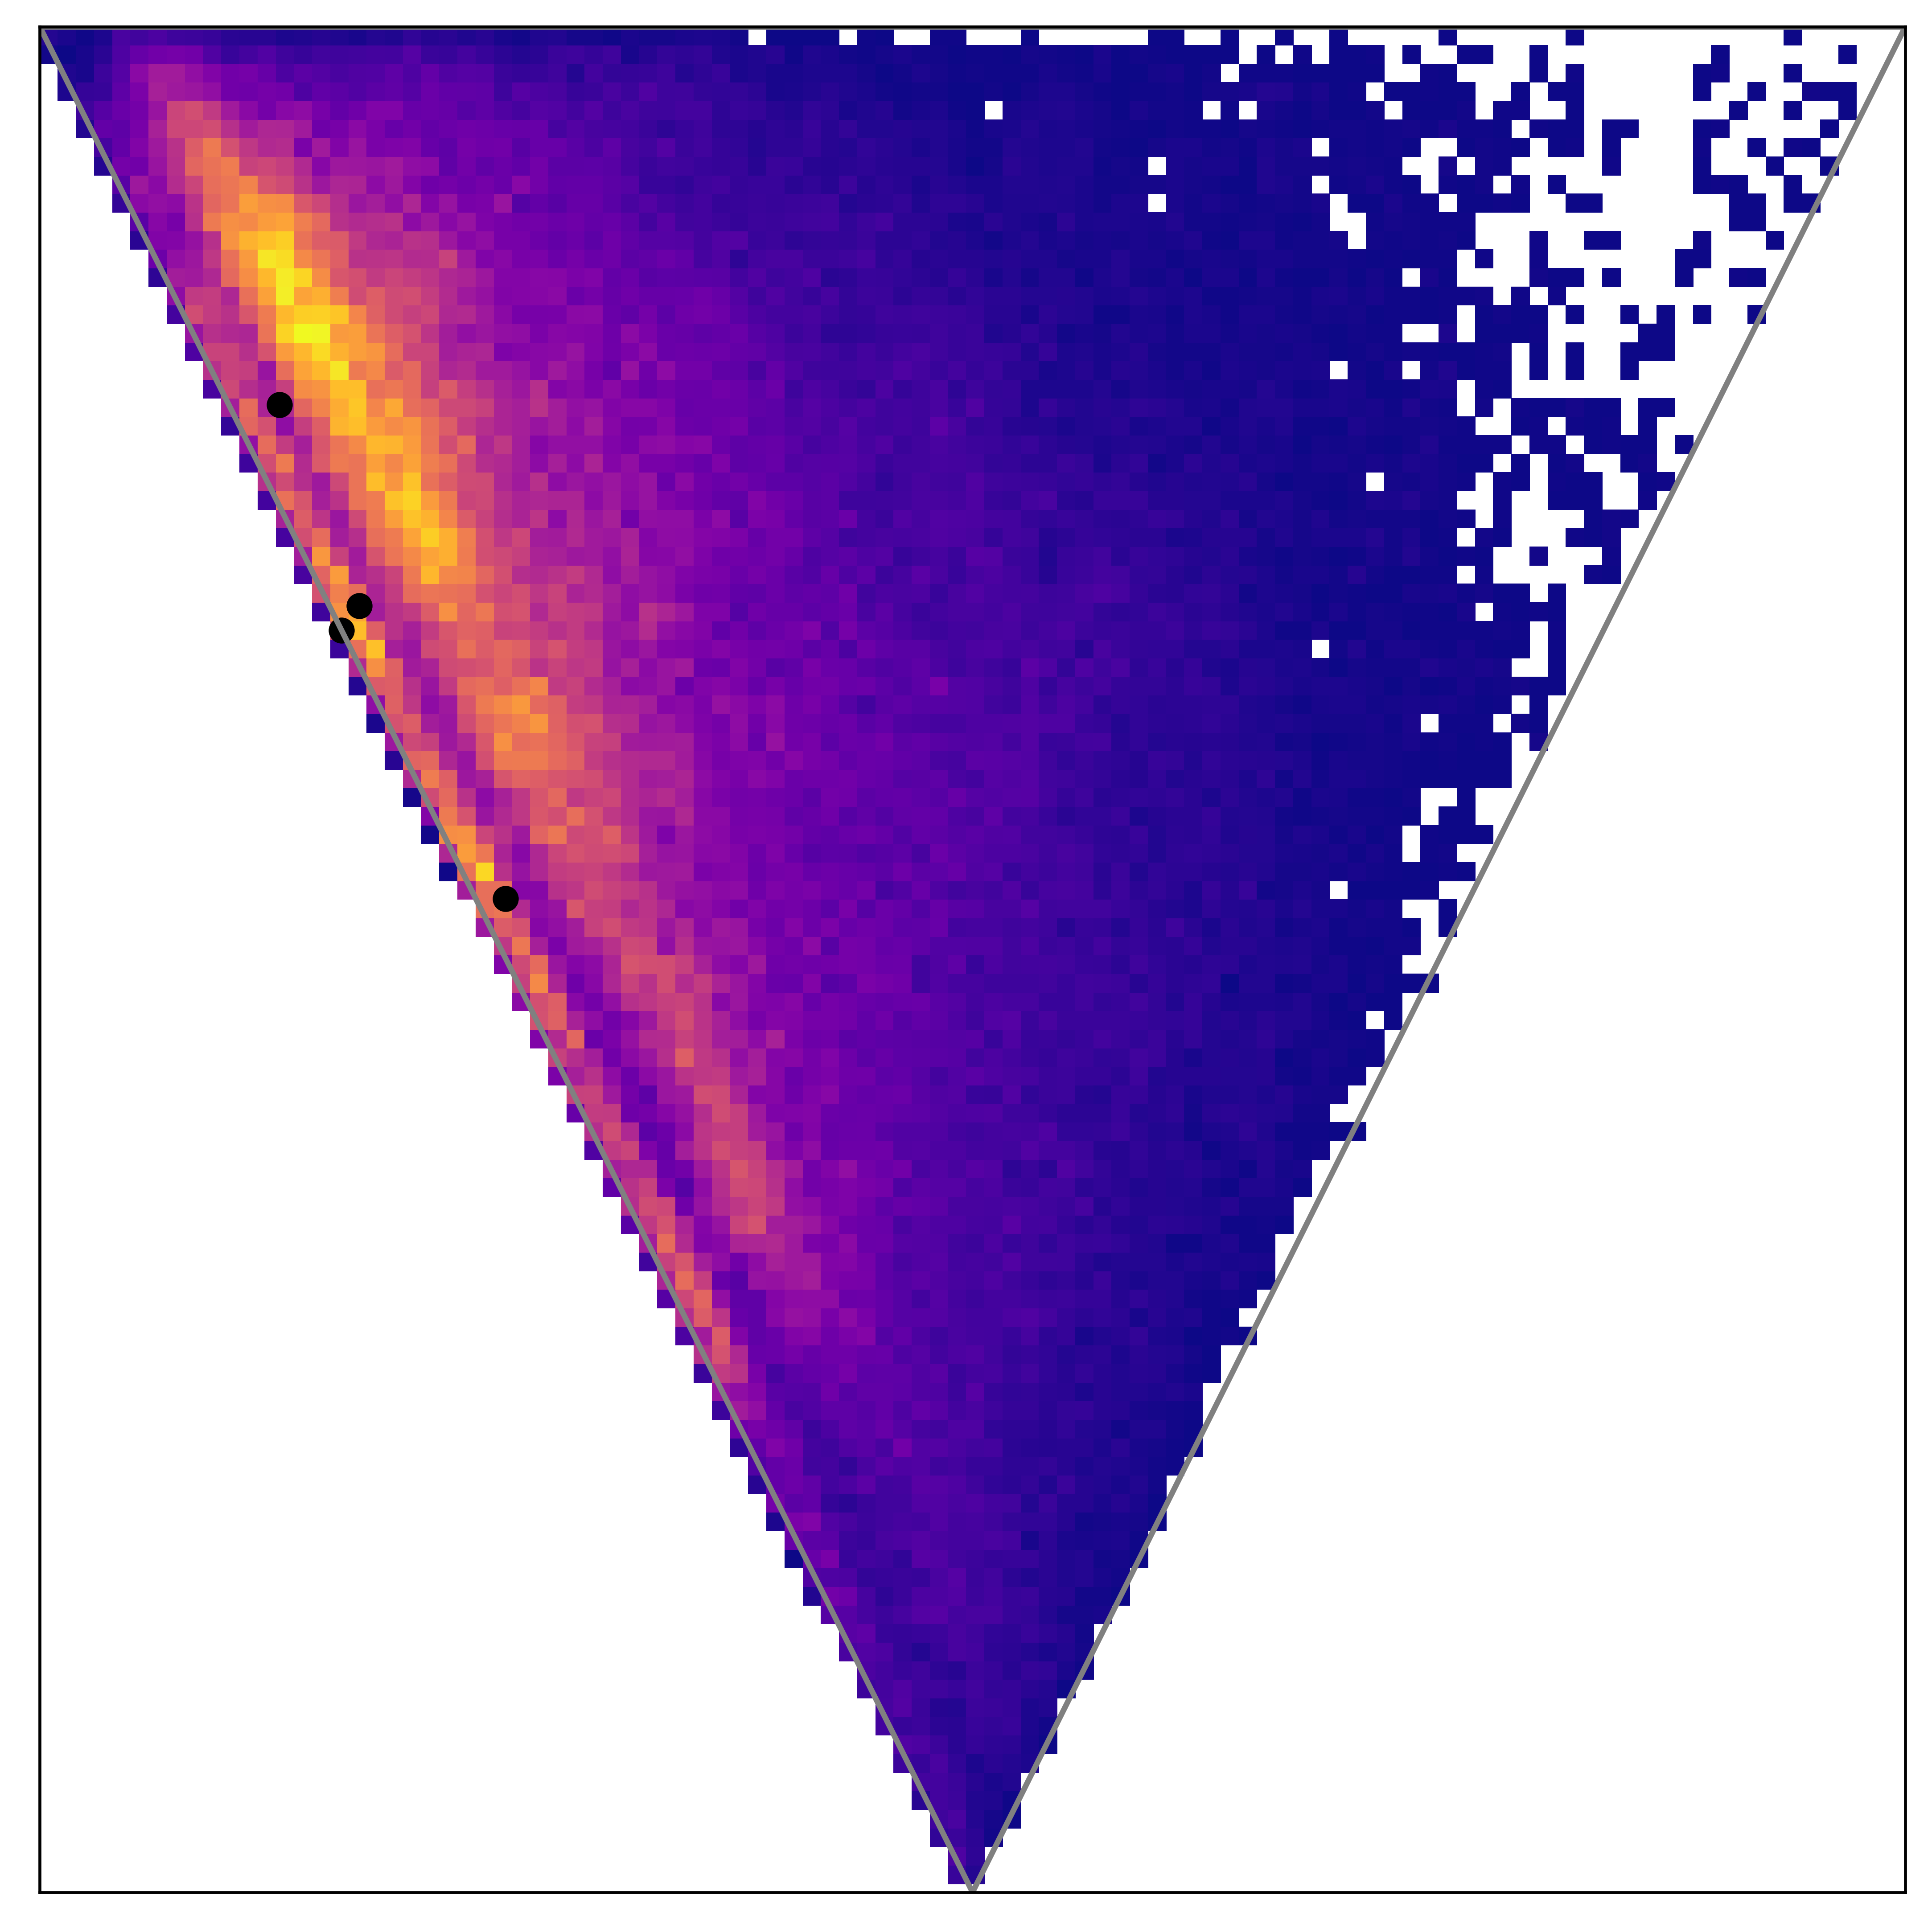

In [10]:
# import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,18),dpi=600)

h = ax.hist2d(list(data_for2d.pmi_x), list(data_for2d.pmi_y),bins=100,cmin=1,cmap="plasma")


ax.set_xlim((0,1))
ax.set_ylim((0.5,1))
ax.plot([0,.5], [1,0.5],color='gray')
ax.plot([.5,1], [0.5,1],color='gray')
ax.plot([0,1], [1,1],color='gray')
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
divider = make_axes_locatable(ax)


# # the 4 amides 
ax.scatter(amide_data.pmi_x,amide_data.pmi_y,color="k")
ax.set_xticks([])
ax.set_yticks([])

# fig.savefig('pmi_all200k_density_900.png', dpi=900)
# plt.close(fig)